

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)).


##Libraries

In [1]:
!pip install gym[box2d]
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [2]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [3]:
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hyperparameters

In [4]:
GAMMA = 0.99
MEMORY_SIZE = 500000
LEARNING_RATE = 6.3e-4
BATCH_SIZE = 128
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.005 #0.995
NUMBER_OF_EPISODES = 1200
MAX_STEPS = 100

## Class ReplayMemory

Memory of transitions for experience replay.

In [5]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size % MEMORY_SIZE
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = self.current_size + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size) % MEMORY_SIZE
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

In [6]:
def create_model(number_of_observations,number_of_actions):
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(256, input_shape=(number_of_observations,), \
                             activation="relu"))
        model.add(keras.layers.Dense(256, activation="relu"))

        model.add(keras.layers.Dense(number_of_actions, activation=None))
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [7]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = create_model(number_of_observations,number_of_actions)
        self.target = create_model(number_of_observations,number_of_actions)
        self.update_target = 250
        self.update_step =0
        self.tau = 0.005 #a veces aparece esto pero no se como meterlo :(
       

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state, verbose=0)
            #print(q_values, "qvalues")
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        if self.update_step % self.update_target ==0:
            self.target.set_weights(self.model.get_weights())
        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states, verbose=0)
        q_next_states = self.target.predict(next_states, verbose=0) #modify esto 
        for i in range(BATCH_SIZE):
             q_val = rewards[i]
             max_action = np.argmax(q_next_states[i]) #esto es la duda si usar next_q o usar q_next_states
             if not terminal_states[i]:
               q_val+= GAMMA * q_next_states[i][max_action]


             q_targets[i][actions[i]] = q_val
             """if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i]) """   

        self.model.train_on_batch(states, q_targets)
        self.update_step +=1

        # Decrease exploration rate
        self.exploration_rate -= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")            

## Environment Lunar Lander v2

Lunar lander simulator from Open Ai Gym:

<p><img height="200px" src="https://www.gymlibrary.dev/_images/lunar_lander.gif" align="center" vspace="20px"</p>

This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.
    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

State vector:
The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.
    
    
An episode is considered a solution if it scores at least 200 points.

Actions:
There are four discrete actions available: 

-do nothing, 

-fire left orientation engine, 

-fire main engine, 

-fire right orientation engine.


In [8]:
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [9]:
from gym import spaces
from gym.wrappers import RecordVideo

In [10]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [11]:
def wrap(env):
  env = RecordVideo(env,'./video',episode_trigger= lambda x: x % 10 ==0)
  return env

In [12]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2")
    
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    print(number_of_actions,number_of_observations)
    #environment = wrap(environment)
    return environment, number_of_observations, number_of_actions

## Main program




In [13]:
import matplotlib.pyplot as plt

In [14]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
start_time = time.perf_counter()
#environment.reset()
#prev_screen = environment.render(mode='rgb_array')

#plt.imshow(prev_screen)
global_step =0 #la idea seria entrenar solo cada 4 samples, pero seria interesante hacer la memoria más pequeñita
puntuaciones, avg_r,r = [],[],[]
while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    episode += 1
    step = 1
    end_episode = False
    state = environment.reset()
    avg_reward =0
    episode_reward =0
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)
        global_step +=1

        # Execute the action in the environment
        state_next, reward, terminal_state, info = environment.step(action)
        """
        Revienta todo si hacemos esto durante entrenamiento, idea feliz? grabar una vez la red este entrenada
        screen = environment.render(mode='rgb_array')plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())"""
        avg_reward +=reward
        episode_reward +=reward
        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)
        # Learn using a batch of experience stored in memory
        if global_step % 4 ==0:
          agent.learn() 
  
        # Detect end of episode and print
        if terminal_state:
            agent.add_score(episode_reward)#duda fuerte: utilizar episode reward o reward?
            # esta es la linea a modificar de condicion de paradaif step >= MAX_STEPS: goal_reached = True
            if np.mean(puntuaciones[-14:]) >= 200:
               print("GOAL REACHED", reward, avg_reward, avg_reward/step, step)
               goal_reached=True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(episode_reward), end = '')
            end_episode = True 
        else:
            state = state_next
            step += 1
    puntuaciones.append(episode_reward)
    avg_r.append(np.mean(puntuaciones[-100:]))
    print(f"Episode {episode} Score: {episode_reward} AVG_score: {np.mean(puntuaciones[-100:])} AVG_REWARD {np.mean(avg_r[-100:])} Exploration rate {agent.exploration_rate} Mem size  {agent.memory.current_size}")
#ipythondisplay.clear_output(wait=True)
#environment.close()
if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

agent.display_scores_graphically()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


4 8


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode   1: score -304.68552868036704 Episode 1 Score: -304.68552868036704 AVG_score: -304.68552868036704 AVG_REWARD -304.68552868036704 Exploration rate 1.0 Mem size  123
Episode   2: score -164.03217100650184 Episode 2 Score: -164.03217100650184 AVG_score: -234.35884984343443 AVG_REWARD -269.52218926190073 Exploration rate 0.6049999999999996 Mem size  206
Episode   3: score -348.03182232352293 Episode 3 Score: -348.03182232352293 AVG_score: -272.2498406701306 AVG_REWARD -270.43140639797736 Exploration rate 0.17499999999999927 Mem size  292
Episode   4: score -97.19434483980355 Episode 4 Score: -97.19434483980355 AVG_score: -228.48596671254882 AVG_REWARD -259.94504647662023 Exploration rate 0.01 Mem size  407
Episode   5: score -234.51308833829245 Episode 5 Score: -234.51308833829245 AVG_score: -229.69139103769754 AVG_REWARD -253.89431538883568 Exploration rate 0.01 Mem size  524
Episode   6: score -203.2091331095344 Episode 6 Score: -203.2091331095344 AVG_score: -225.27768138300368 

KeyboardInterrupt: ignored

In [18]:
for episode in range(10): #eval durante 10 epis
  total_rewards =0
  state = environment.reset()
  print(f'Episode {episode}')
  print('------------')
  avg_reward=0
  episode_reward=0
  while True:
        action = agent.select(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, info = environment.step(action)
       
        avg_reward +=reward
        episode_reward +=reward
        state = state_next
        if terminal_state:
          break
  print(avg_reward)

    


------------
-97.88377079960044
------------
-362.3413506051505
------------
-123.78886761314018
------------
226.4976683076719
------------
268.27550478864396
------------
-121.86014277208906
------------
-85.87002416398403
------------
224.8722318239724
------------
-90.82063853646156
------------
270.9610624964699


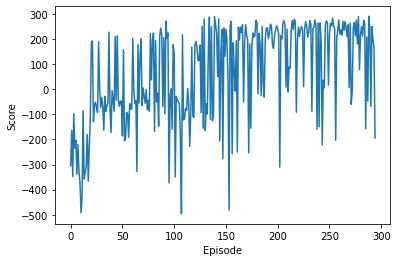

In [19]:
agent.display_scores_graphically()